# Example on MNIST

This example illustrates how ZerO works and avoids the training degeneracy (described by Thereom 1 in the paper). 

Link of the paper: https://arxiv.org/abs/2110.12661

## Setup

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import math
from scipy.linalg import hadamard


### Model
We consider a 4-layer multi-layer perceptron (MLP) where the hidden dimension is fixed. The models based on **random, partial identity, and ZerO** initialization are defined as follows:

In [2]:
def ZerO_Init_on_matrix(matrix_tensor):
    # Algorithm 1 in the paper.
    
    m = matrix_tensor.size(0)
    n = matrix_tensor.size(1)
    
    if m <= n:
        init_matrix = torch.nn.init.eye_(torch.empty(m, n))
    elif m > n:
        clog_m = math.ceil(math.log2(m))
        p = 2**(clog_m)
        init_matrix = torch.nn.init.eye_(torch.empty(m, p))\
                    @ (torch.tensor(hadamard(p)).float()/(2**(clog_m/2)))\
                    @ torch.nn.init.eye_(torch.empty(p, n))
    return init_matrix

def More_Init_on_matrix(matrix_tensor):
    # Algorithm 1 in the paper.
    
    m = matrix_tensor.size(0)
    n = matrix_tensor.size(1)
    
    clog_m = math.ceil(math.log2( max(m,n) ))
    p = 2**(clog_m)
    init_matrix = torch.nn.init.eye_(torch.empty(m, p))\
                @ (torch.tensor(hadamard(p)).float()/(2**(clog_m/2)))\
                @ torch.nn.init.eye_(torch.empty(p, n))
    if m <= n:
        print("More initialized", matrix_tensor.shape, "to", init_matrix)
    
    return init_matrix

def Identity_Init_on_matrix(matrix_tensor):
    # Definition 1 in the paper
    # See https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.eye_ for details. Preserves the identity of the inputs in Linear layers, where as many inputs are preserved as possible, the same as partial identity matrix.
    
    m = matrix_tensor.size(0)
    n = matrix_tensor.size(1)
    print("Init matrix", matrix_tensor.shape, "with m={}, n={}".format(m, n))
    
    init_matrix = torch.nn.init.eye_(torch.empty(m, n))
    
    return init_matrix

def OnE_Init_on_matrix(matrix_tensor):
    m = matrix_tensor.size(0)
    n = matrix_tensor.size(1)
    init_matrix = torch.nn.init.eye_(torch.empty(m,n))
    if m <= n:
        print("Nothing extra to be done to OnE-Initialize", init_matrix.shape);
    elif m > n:
        print("OnE-Initializing", init_matrix.shape)
        init_matrix = torch.nn.init.eye_(torch.empty(m,n))
        rng = np.random.default_rng()
        for row in range(n, m, 1):
            col = rng.integers(low=0, high=n-1, endpoint=True)
            #print("Random column selected to be initialized to OnE (0 to {}): {}".format(n-1, col))
            init_matrix[row, col] = 1
    else:
        assert(False)
    return init_matrix
            

def Spray_Init_on_matrix(matrix_tensor):
    """ Fill like OnE init, but invert effect"""
    m = matrix_tensor.size(0)
    n = matrix_tensor.size(1)
    init_matrix = torch.nn.init.eye_(torch.empty(m,n))
    if m <= n:
        print("Nothing extra to be done to OnE-Initialize", init_matrix.shape);
    elif m > n:
        print("OnE-Initializing", init_matrix.shape)
        init_matrix = torch.nn.init.eye_(torch.empty(m,n))
        rng = np.random.default_rng()
        for row in range(n, m, 1):
            col = rng.integers(low=0, high=n-1, endpoint=True)
            #print("Random column selected to be initialized to OnE (0 to {}): {}".format(n-1, col))
            init_matrix[row, col] = 1
    else:
        assert(False)
    # Invert effect
    fix_value = 1 / (n-1)
    print("Spray initializing to value {}".format(fix_value))
    init_matrix = fix_value * (torch.ones(m,n) - init_matrix)
    return init_matrix

In [3]:
class MLP(nn.Module):
    '''
    a standard model with 4 hidden layers
    '''
    def __init__(self, n_h=1024, init='ZerO'):
        super(MLP, self).__init__()
        self.init = init
        self.n_h = n_h
        self.l1 = nn.Linear(784, 784, bias=True)  
        self.l2 = nn.Linear(784, self.n_h, bias=True)  
        self.l3 = nn.Linear(self.n_h, self.n_h, bias=True)  
        self.l4 = nn.Linear(self.n_h, 10, bias=True)  

        self.apply(self._init_weights)
        
    def forward(self, x): 

        x = x.view(-1, 28 * 28)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = self.l4(x)
        return F.log_softmax(x)
    
    def _init_weights(self, m):
        
        if self.init == 'ZerO':
            if isinstance(m, nn.Linear):
                m.weight.data = ZerO_Init_on_matrix(m.weight.data)
                
        elif self.init == 'Partial_Identity':
            if isinstance(m, nn.Linear):
                m.weight.data = Identity_Init_on_matrix(m.weight.data)
        
        elif self.init == 'Random':
            if isinstance(m, nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)
        elif self.init == 'OnE':
            if isinstance(m, nn.Linear):
                m.weight.data = OnE_Init_on_matrix(m.weight.data)
        elif self.init == 'Spray':
            if isinstance(m, nn.Linear):
                m.weight.data = Spray_Init_on_matrix(m.weight.data)
        elif self.init == 'More':
            if isinstance(m, nn.Linear):
                m.weight.data = More_Init_on_matrix(m.weight.data)
        else:
            assert(False)
                
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0.01)

### Measurements

In [4]:
def compute_rank(tensor):

    tensor = tensor.detach().cpu()
    rank = np.linalg.matrix_rank(tensor, tol=0.0001)
    
    return rank



### Training Pipeline on MNIST

from https://github.com/pytorch/examples/blob/main/mnist/main.py

In [5]:
class Optimizer(torch.optim.SGD):
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                d_p = p.grad.data
                p.data.add_(d_p, alpha=-group['lr']) 

        return loss

def train(args, model, device, train_loader, optimizer, epoch, train_acc_list, train_loss_list, rank_list_dict):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy({:.0f}%)'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                100. * correct / len(train_loader.dataset)))
            
            # log metric
            train_acc_list.append(100. * correct / len(train_loader.dataset))
            train_loss_list.append(loss.item())
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if 'l3' in name:
                        if name not in rank_list_dict:
                            rank_list_dict[name] = []
                            
                        # compute stable rank of the residual component
                        rank_list_dict[name].append(compute_rank(param.data - torch.eye(param.data.size(0)).to(param.data.device)))
                
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 100. * correct / len(test_loader.dataset)


def train_model(model, file_dir=None):
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=1, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=True,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')

    parser.add_argument('--name', type=str, default='test')  
    
    parser.add_argument('--init', type=str, default='ZerO') 

    args = parser.parse_args([])
    print("Parsed args:", args)
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    model = model.to(device)
    # debug
    print(" ---------- Now training init={} ----------".format(args.init))
    print("v ===== Before training (args.init={}) =====".format(args.init))
    for name, params in model.named_parameters():
        if "bias" not in name:
            print(params.shape)
            print(name, params.data)
    print("^ ===== Before training (args.init={}) =====".format(args.init))   
    optimizer = Optimizer(model.parameters(), lr=args.lr)
 
    # logging metric    
    train_acc_list = []
    train_loss_list = []
    rank_list_dict = {}
    
    scheduler = StepLR(optimizer, step_size=12, gamma=args.gamma)
    
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch, train_acc_list, train_loss_list, rank_list_dict)
        test(model, device, test_loader)
        scheduler.step()
    # debug2
    print("v ===== After training (args.init={}) =====".format(args.init))
    for name, params in model.named_parameters():
        if "bias" not in name:
            print(params.shape)
            print(name, params.data)
    print("^ ===== After training (args.init={}) =====".format(args.init))
    optimizer = Optimizer(model.parameters(), lr=args.lr)
    if args.save_model:
        torch.save(model.state_dict(), args.init + "_mnist_cnn.pt")
        
    return rank_list_dict

In [6]:
# plotting
import numpy as np
import matplotlib.pyplot as plt

## Verification of Theorem 1 (Figure 3 in the paper)

### Figure 3 (left): identity initialization under different widths

We show that the rank constraints (training degeneracy) happen no matter what the width is. The ranks are always smaller than the input dimension (784=28 * 28).

Init matrix torch.Size([784, 784]) with m=784, n=784
Init matrix torch.Size([256, 784]) with m=256, n=784
Init matrix torch.Size([256, 256]) with m=256, n=256
Init matrix torch.Size([10, 256]) with m=10, n=256
Parsed args: Namespace(batch_size=64, epochs=1, gamma=0.7, init='ZerO', log_interval=50, lr=0.1, name='test', no_cuda=True, save_model=False, seed=1, test_batch_size=1000)
 ---------- Now training init=ZerO ----------
v ===== Before training (args.init=ZerO) =====
torch.Size([784, 784])
l1.weight tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
torch.Size([256, 784])
l2.weight tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0

/tmp/ipykernel_3342/766049207.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.365503	Accuracy(4%)
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.349470	Accuracy(9%)
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.584853	Accuracy(13%)
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.224645	Accuracy(18%)
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.596284	Accuracy(23%)
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.206185	Accuracy(28%)
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.626288	Accuracy(32%)
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.335312	Accuracy(37%)
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.400203	Accuracy(42%)
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.131562	Accuracy(47%)
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.106835	Accuracy(52%)
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.275359	Accuracy(57%)
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.100675	Accuracy(62%)
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.128090	Accuracy(67%)
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.116398	Accuracy(72%)
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.241

/tmp/ipykernel_3342/3440958.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5)


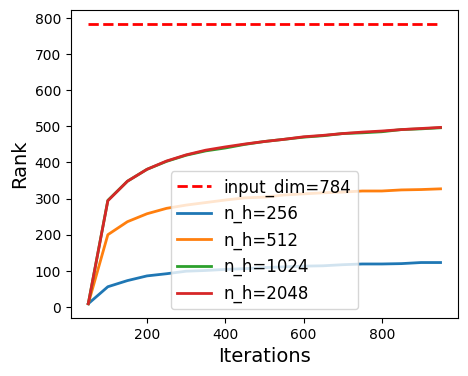

In [7]:
#n_h_2048_rank_list_dict_Spray = train_model(MLP(init='Spray', n_h=2048))
#n_h_2048_rank_list_dict_OnE = train_model(MLP(init='OnE', n_h=2048))
n_h_256_rank_list_dict = train_model(MLP(init='Partial_Identity', n_h=256))
n_h_512_rank_list_dict = train_model(MLP(init='Partial_Identity', n_h=512))
n_h_1024_rank_list_dict = train_model(MLP(init='Partial_Identity', n_h=1024))
n_h_2048_rank_list_dict = train_model(MLP(init='Partial_Identity', n_h=2048))

fig, ax = plt.subplots(1,1, figsize=(5,4), gridspec_kw = {'wspace':0.5, 'hspace':0.5})

x_axis = np.arange(1, len(n_h_512_rank_list_dict['l3.weight'])+1)
x_axis = x_axis * 50

# generate a line of 784
input_dim_line = np.ones(len(n_h_512_rank_list_dict['l3.weight'])) * 784

ax.plot(x_axis, input_dim_line, label='input_dim=784', linestyle='dashed', color='red', linewidth='2')
ax.plot(x_axis, n_h_256_rank_list_dict['l3.weight'], label='n_h=256', linewidth='2')
ax.plot(x_axis, n_h_512_rank_list_dict['l3.weight'], label='n_h=512', linewidth='2')
ax.plot(x_axis, n_h_1024_rank_list_dict['l3.weight'], label='n_h=1024', linewidth='2')
ax.plot(x_axis, n_h_2048_rank_list_dict['l3.weight'], label='n_h=2048', linewidth='2')
#ax.plot(x_axis, n_h_2048_rank_list_dict_OnE['l3.weight'], label='n_h=2048_OnE', linewidth='2')
#ax.plot(x_axis, n_h_2048_rank_list_dict_Spray['l3.weight'], label='n_h=2048_Spray', linewidth='2')

ax.set_ylabel('Rank', fontsize=14)
ax.set_xlabel('Iterations', fontsize=14) 
ax.legend(fontsize=12)

fig.tight_layout(w_pad=0.5)
plt.show()
fig.savefig('./figure_3_left.pdf', bbox_inches='tight')

### Figure 3 (right): Hadamard transfrom breaks training degeneracy

We show that when initializing dimension-increasing layer with Hadamard transform, the rank constraints (training degeneracy) not exsist any more. The rank can be greater than the input dimension during training.

More initialized torch.Size([784, 784]) to tensor([[ 0.0312,  0.0312,  0.0312,  ...,  0.0312,  0.0312,  0.0312],
        [ 0.0312, -0.0312,  0.0312,  ..., -0.0312,  0.0312, -0.0312],
        [ 0.0312,  0.0312, -0.0312,  ...,  0.0312, -0.0312, -0.0312],
        ...,
        [ 0.0312, -0.0312,  0.0312,  ..., -0.0312,  0.0312, -0.0312],
        [ 0.0312,  0.0312, -0.0312,  ...,  0.0312, -0.0312, -0.0312],
        [ 0.0312, -0.0312, -0.0312,  ..., -0.0312, -0.0312,  0.0312]])
More initialized torch.Size([1024, 1024]) to tensor([[ 0.0312,  0.0312,  0.0312,  ...,  0.0312,  0.0312,  0.0312],
        [ 0.0312, -0.0312,  0.0312,  ..., -0.0312,  0.0312, -0.0312],
        [ 0.0312,  0.0312, -0.0312,  ...,  0.0312, -0.0312, -0.0312],
        ...,
        [ 0.0312, -0.0312,  0.0312,  ..., -0.0312,  0.0312, -0.0312],
        [ 0.0312,  0.0312, -0.0312,  ...,  0.0312, -0.0312, -0.0312],
        [ 0.0312, -0.0312, -0.0312,  ..., -0.0312, -0.0312,  0.0312]])
More initialized torch.Size([10, 1024]) to t

/tmp/ipykernel_3342/766049207.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.462197	Accuracy(3%)
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.391420	Accuracy(8%)
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.508553	Accuracy(13%)
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.212969	Accuracy(17%)
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.502711	Accuracy(22%)
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.164175	Accuracy(27%)
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.528422	Accuracy(32%)
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.260929	Accuracy(37%)
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.310096	Accuracy(42%)
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.095579	Accuracy(47%)
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.104701	Accuracy(52%)
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.224685	Accuracy(57%)
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.059893	Accuracy(62%)
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.084684	Accuracy(67%)
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.083548	Accuracy(72%)
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.149

/tmp/ipykernel_3342/3762902632.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.5)


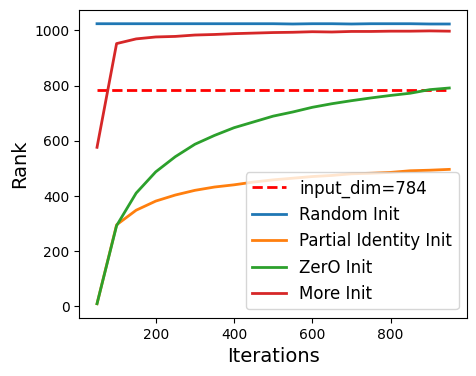

In [8]:
More_init_rank_list_dict = train_model(MLP(init='More', n_h=1024))
#Spray_init_rank_list_dict = train_model(MLP(init='Spray', n_h=1024))
#OnE_init_rank_list_dict = train_model(MLP(init='OnE', n_h=1024))
ZerO_init_rank_list_dict = train_model(MLP(init='ZerO', n_h=1024))
partial_identity_init_rank_list_dict = train_model(MLP(init='Partial_Identity', n_h=1024))
random_init_rank_list_dict = train_model(MLP(init='Random', n_h=1024))

fig, ax = plt.subplots(1,1, figsize=(5,4), gridspec_kw = {'wspace':0.5, 'hspace':0.5})

x_axis = np.arange(1, len(n_h_512_rank_list_dict['l3.weight'])+1)
x_axis = x_axis * 50

# generate a line of 784
input_dim_line = np.ones(len(n_h_512_rank_list_dict['l3.weight'])) * 784

ax.plot(x_axis, input_dim_line, label='input_dim=784', linestyle='dashed', color='red', linewidth='2')
ax.plot(x_axis, random_init_rank_list_dict['l3.weight'], label='Random Init', linewidth='2')
ax.plot(x_axis, partial_identity_init_rank_list_dict['l3.weight'], label='Partial Identity Init', linewidth='2')
ax.plot(x_axis, ZerO_init_rank_list_dict['l3.weight'], label='ZerO Init', linewidth='2')
#ax.plot(x_axis, OnE_init_rank_list_dict['l3.weight'], label='OnE Init', linewidth='2')
#ax.plot(x_axis, Spray_init_rank_list_dict['l3.weight'], label='Spray Init', linewidth='2')
ax.plot(x_axis, More_init_rank_list_dict['l3.weight'], label='More Init', linewidth='2')


ax.set_ylabel('Rank', fontsize=14)
ax.set_xlabel('Iterations', fontsize=14) 
ax.legend(fontsize=12)

fig.tight_layout(w_pad=0.5)
plt.show()
fig.savefig('./figure_3_right.pdf', bbox_inches='tight')
